<a href="https://colab.research.google.com/github/egsu20/prac/blob/main/15_dc_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Keras Deep Convolution Gan으로 손글씨 모방

1. 패키지 수입 및 하이퍼 파라미터 설정

In [ ]:
# 패키지 수입
import matplotlib.pyplot as plt 
import numpy as np
import os
import glob

from time import time
from keras.datasets import mnist # 감별자는 실제 데이터를 확인해야함
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose 
from keras.layers import BatchNormalization, Activation
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU, Dropout, UpSampling2D

In [ ]:
# 하이퍼 파라미터 지정
MY_EPOCH = 5000         # 학습 횟수
MY_BATCH = 500  
MY_NOISE = 100           # 생성자가 사용하는 노이즈 벡터. 임의의 수 100개로 가짜 생성
MY_SHAPE = (28, 28, 1)  
MY_DROP = 0.4            # rate 정보
MY_ALPHA = 0.01
TRAIN_MODE = 1

In [ ]:
# 출력 이미지 폴더 생성
MY_FOLDER = 'output/' 
os.makedirs(MY_FOLDER, exist_ok=True) # 이미 파일이 있는 경우, 그대로 진행

# 폴더 안에 파일 지우기(초기화)
for f in glob.glob(MY_FOLDER + '*'): # 폴더 내 모든 파일 접근
    os.remove(f)

2. 데이터 처리

In [ ]:
# 데이터 불러오기
def read_data():
    # GAN은 비지도 학습. 라벨 x
    (X_train, _), (_, _) = mnist.load_data() # 4분할 데이터 중 X_train만 사용

    # 샘플 확인
    #print(X_train[0])
    #plt.imshow(X_train[0], cmap='gray')
    
    # 데이터 스케일링 [-1, 1] 
    X_train = X_train / 127.5 - 1.0
    #print(X_train[0])

    # 채널 정보 추가
    #print(X_train.shape)
    X_train = X_train.reshape(60000, 28, 28, 1)

    return X_train

3. 인공 신경망 구현

In [ ]:
# 생성자 구현
def build_generator():
    model = Sequential()

    # 입력층과 블록 2
    model.add(Dense(units=3136,
                    input_dim=MY_NOISE))
    
    model.add(BatchNormalization()) # 여기에 activation 사용 불가
    model.add(Activation('relu'))

    # 블록 3
    model.add(Reshape((7, 7, 64)))
    model.add(Dropout(MY_DROP))

    # 블록 4
    model.add(UpSampling2D(size=2))
    model.add(Conv2DTranspose(filters=64,
                              kernel_size=5, # 필터 사이즈
                              strides=1, # 보폭
                              padding='same'))
    
    model.add(BatchNormalization()) # 여기에 activation 사용 불가
    model.add(Activation('relu'))

    # 블록 5
    model.add(UpSampling2D(size=2))
    model.add(Conv2DTranspose(filters=64,
                              kernel_size=5, # 필터 사이즈
                              strides=1, # 보폭
                              padding='same'))
    
    model.add(BatchNormalization()) # 여기에 activation 사용 불가
    model.add(Activation('relu'))

    # 블록 6
    model.add(Conv2DTranspose(filters=64,
                              kernel_size=5, # 필터 사이즈
                              strides=1, # 보폭
                              padding='same'))
    
    model.add(BatchNormalization()) # 여기에 activation 사용 불가
    model.add(Activation('relu'))

    # 블록 7
    model.add(Conv2DTranspose(filters=1,
                              kernel_size=5, # 필터 사이즈
                              strides=1, # 보폭
                              padding='same',
                              activation='tanh')) # 실제 데이터를 [-1,1]로 스케일링 하였으므로
                                                  # 생성된 데이터도 스케일링 해줌

    #print('생성자 요약')
    #model.summary()
    return model

In [ ]:
# 감별자 구현
# DC GAN에서 감별자 출력은 [0, 1]
# 확률이 0 : 주어진 이미지가 가짜 / 확률이 1 : 주어진 이미지가 진짜
def build_discriminator():
    model = Sequential()

    # 입력층과 블록 2
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=2,
                     input_shape=MY_SHAPE,
                     padding='same'))
    
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))

    # 블록 3
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=2,
                     input_shape=MY_SHAPE,
                     padding='same'))
    
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))

    # 블록 4
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=2,
                     input_shape=MY_SHAPE,
                     padding='same'))
    
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))

    # 블록 5
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,  # 블록 4 유지
                     input_shape=MY_SHAPE,
                     padding='same'))
    
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))

    # 블록 6 
    model.add(Flatten())
    
    # 블록 7
    model.add(Dense(units=1,
                   activation='sigmoid'))

    #print('감별자 요약')
    #model.summary()

    return model

In [ ]:
# DC_GAN 구현
def build_GAN():
    model = Sequential()

    # 생성자 만들기
    generator = build_generator()

    # 감별자 만들기
    discriminator = build_discriminator()
    discriminator.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['acc'])
    
    discriminator.trainable = False # 생성자를 학습할 때 감별자는 변하면 안됨 -> 고정

    # GAN 만들기
    model.add(generator)
    model.add(discriminator)

    # 생성자 학습용 최적화/손실 함수
    model.compile(optimizer='adam',
                  loss='binary_crossentropy')
    
    # 생성자 학습시엔 감별자 필요, 반대의 경우엔 필요 x
    

    #print('GAN 요약')
    #model.summary()

    return generator, discriminator, model

4. 인공 신경망 학습

In [ ]:
# 생성자 학습 - noise와 판별자가 대답하길 바라는 값 생성, train_on_batch(순,역)
def train_generator():
    # 가짜 이미지 한 batch 만들기
    # 균일 분포 사용
    #MY_BATCH = 1 : 테스트
    noise = np.random.uniform(-1, 1, (MY_BATCH, MY_NOISE)) # random uniform : 표준 균일 분포로 임의의 수 생성
                                                           # 표준은 0~1 사이의 수
                                                           # random normal : 표준 정규 분포로 임의의 수 생성
    #print(noise.shape)
    all_1 = np.ones((MY_BATCH, 1)) # 500 말함. 1차원

    #fake = generator.predict(noise)
    #fake = fake.reshape(28, 28)
    #plt.imshow(fake)

    # 감별자 속이기 훈련
    loss = gan.train_on_batch(noise, all_1)
    return loss

In [ ]:
# 감별자 학습
def train_discriminator():
    # 진짜 이미지 한 batch로 학습
    total = X_train.shape[0]
    pick = np.random.randint(0, total, MY_BATCH)
    
    # 진짜 이미지 500개
    real = X_train[pick]

    all_1 = np.ones((MY_BATCH,1)) # 1이 MY_BATCH개 필요.
    loss_real = discriminator.train_on_batch(real, all_1)
    #print(loss_real)

    # 가짜 이미지 한 batch로
    noise = np.random.uniform(-1, 1, (MY_BATCH, MY_NOISE))
    fake = generator.predict(noise)
    all_0 = np.zeros((MY_BATCH,1)) # 경찰이 0으로 답하길 원함
    loss_fake = discriminator.train_on_batch(fake, all_0) # 손실값 평균
    
    #print(loss_fake)

    loss = np.add(loss_real, loss_fake) / 2
    #print(loss)

    return loss

In [ ]:
# 샘플 이미지 출력
def sample(epoch):
    noise = np.random.uniform(-1,1,(16, MY_NOISE))
    fake = generator.predict(noise) # 예측. 생성자가 만들어 낸 16개의 이미지
    fake = np.squeeze(fake) # 채널 정보가 있으면 안됨
    
    # 캔버스 만들기
    file, canvas = plt.subplots(4, 4, figsize=(5, 5))

    # fake에 이미지들을 canvas로 옮김
    cnt = 0
    for i in range(4): # 행
        for j in range(4): # 열
          canvas[i, j].imshow(fake[cnt], cmap='gray')
          canvas[i, j].axis('off')
          cnt += 1

    plt.show() 

In [ ]:
# GAN 학습
def train_GAN():
    begin = time()
    print('학습 시작')

    for epoch in range(MY_EPOCH):
        d_loss = train_discriminator()
        g_loss = train_generator()

        if epoch % 100 == 0:
            print('에포크 :', epoch,
                  '생성자 손실 : {:.3f}'.format(g_loss),
                  '감별자 손실 : {:.3f}'.format(d_loss[0]))
            
            sample(epoch)

        end = time()
        #print('총 학습시간 : {:.2f}'.format(end - begin))

5. 컨트롤 타워

학습 시작
에포크 : 0 생성자 손실 : 0.518 감별자 손실 : 0.711


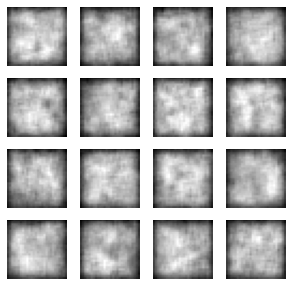

에포크 : 100 생성자 손실 : 0.000 감별자 손실 : 0.000


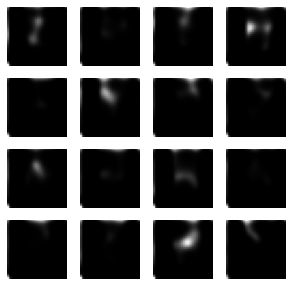

에포크 : 200 생성자 손실 : 0.143 감별자 손실 : 0.019


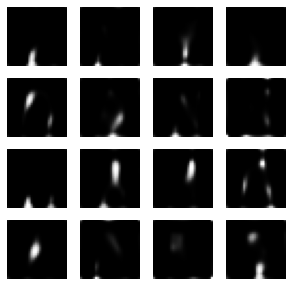

에포크 : 300 생성자 손실 : 1.898 감별자 손실 : 0.123


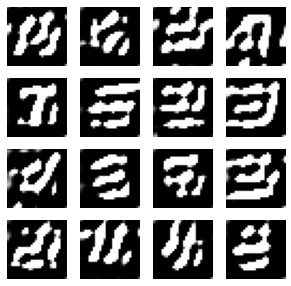

에포크 : 400 생성자 손실 : 4.076 감별자 손실 : 0.198


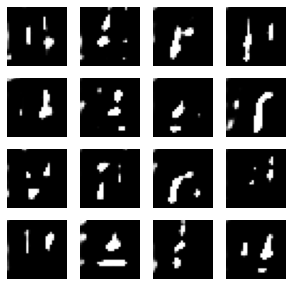

에포크 : 500 생성자 손실 : 5.157 감별자 손실 : 0.125


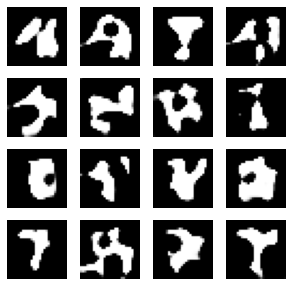

에포크 : 600 생성자 손실 : 2.216 감별자 손실 : 0.217


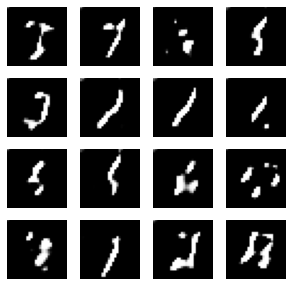

에포크 : 700 생성자 손실 : 3.276 감별자 손실 : 0.144


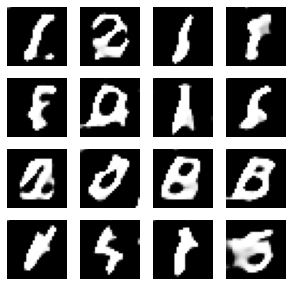

에포크 : 800 생성자 손실 : 1.560 감별자 손실 : 0.339


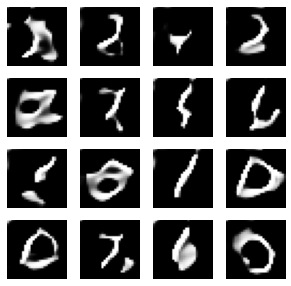

에포크 : 900 생성자 손실 : 1.328 감별자 손실 : 0.090


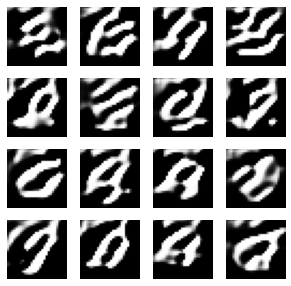

에포크 : 1000 생성자 손실 : 2.348 감별자 손실 : 0.284


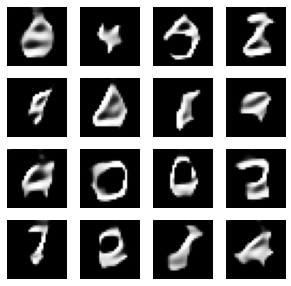

에포크 : 1100 생성자 손실 : 2.617 감별자 손실 : 0.321


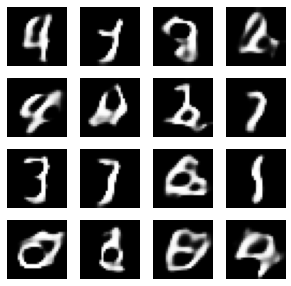

에포크 : 1200 생성자 손실 : 1.930 감별자 손실 : 0.330


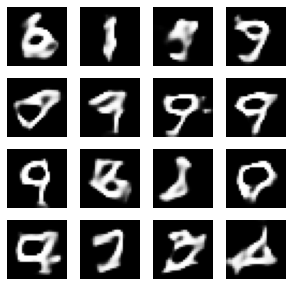

에포크 : 1300 생성자 손실 : 2.640 감별자 손실 : 0.283


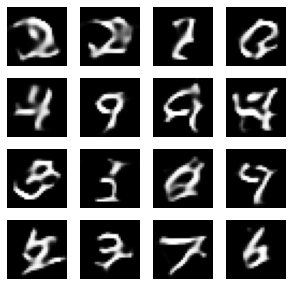

에포크 : 1400 생성자 손실 : 1.895 감별자 손실 : 0.387


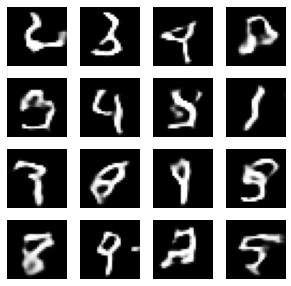

에포크 : 1500 생성자 손실 : 1.982 감별자 손실 : 0.416


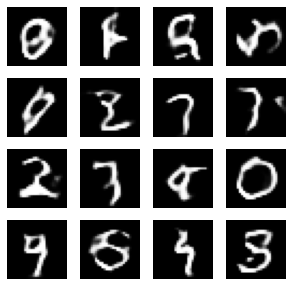

에포크 : 1600 생성자 손실 : 1.815 감별자 손실 : 0.382


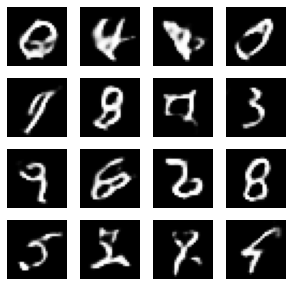

에포크 : 1700 생성자 손실 : 1.569 감별자 손실 : 0.412


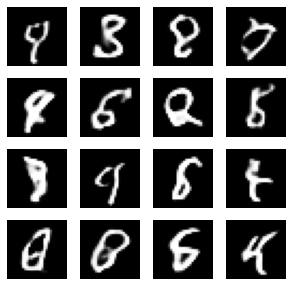

에포크 : 1800 생성자 손실 : 1.660 감별자 손실 : 0.454


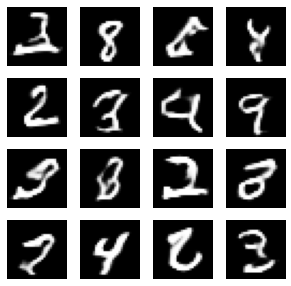

에포크 : 1900 생성자 손실 : 1.766 감별자 손실 : 0.487


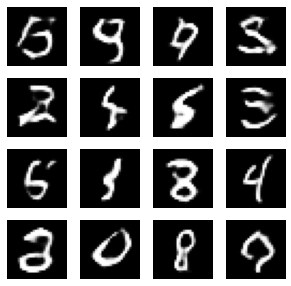

에포크 : 2000 생성자 손실 : 1.695 감별자 손실 : 0.458


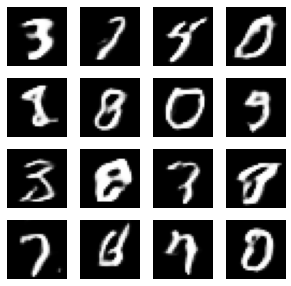

에포크 : 2100 생성자 손실 : 1.853 감별자 손실 : 0.420


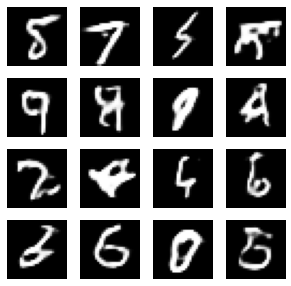

에포크 : 2200 생성자 손실 : 1.681 감별자 손실 : 0.454


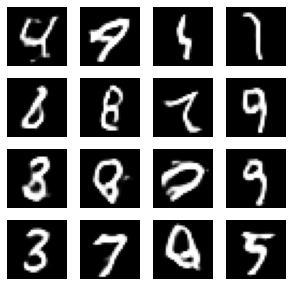

에포크 : 2300 생성자 손실 : 1.468 감별자 손실 : 0.493


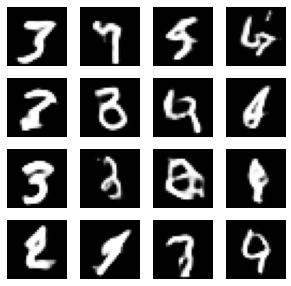

에포크 : 2400 생성자 손실 : 1.608 감별자 손실 : 0.494


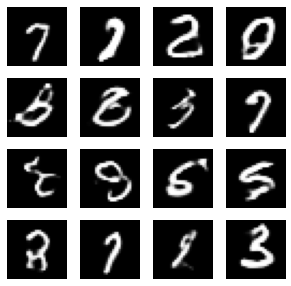

에포크 : 2500 생성자 손실 : 1.625 감별자 손실 : 0.475


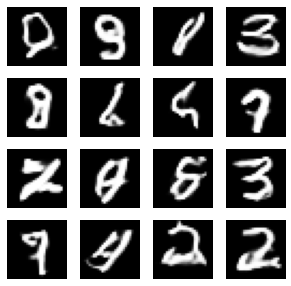

에포크 : 2600 생성자 손실 : 1.493 감별자 손실 : 0.514


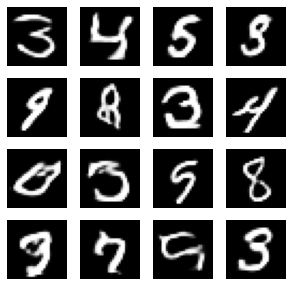

에포크 : 2700 생성자 손실 : 1.424 감별자 손실 : 0.492


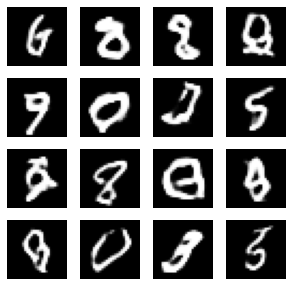

에포크 : 2800 생성자 손실 : 1.688 감별자 손실 : 0.471


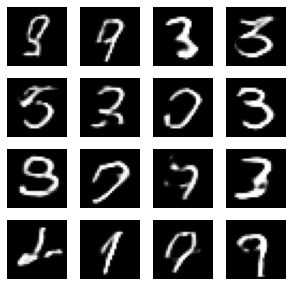

에포크 : 2900 생성자 손실 : 1.928 감별자 손실 : 0.400


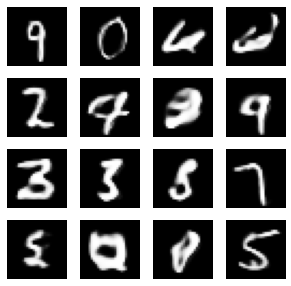

에포크 : 3000 생성자 손실 : 1.378 감별자 손실 : 0.517


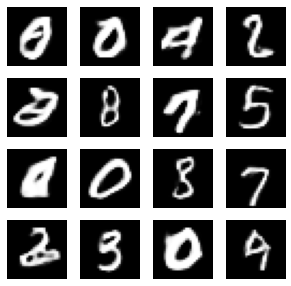

에포크 : 3100 생성자 손실 : 1.467 감별자 손실 : 0.448


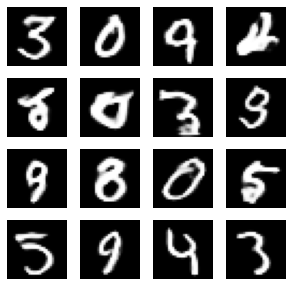

에포크 : 3200 생성자 손실 : 1.622 감별자 손실 : 0.438


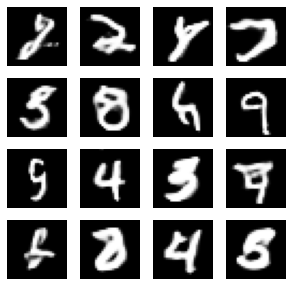

에포크 : 3300 생성자 손실 : 1.605 감별자 손실 : 0.480


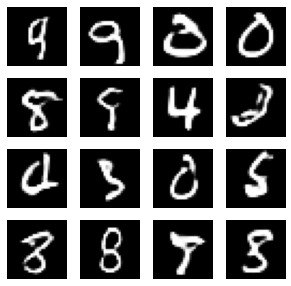

에포크 : 3400 생성자 손실 : 1.643 감별자 손실 : 0.475


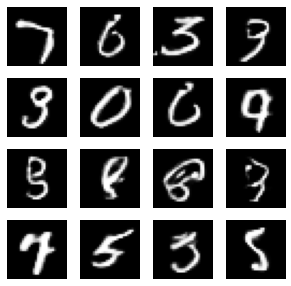

에포크 : 3500 생성자 손실 : 1.771 감별자 손실 : 0.469


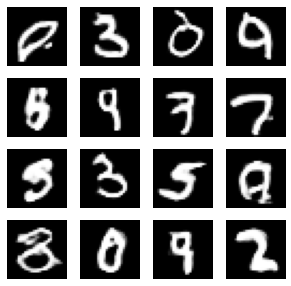

에포크 : 3600 생성자 손실 : 1.454 감별자 손실 : 0.579


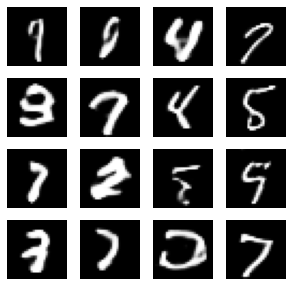

에포크 : 3700 생성자 손실 : 1.443 감별자 손실 : 0.573


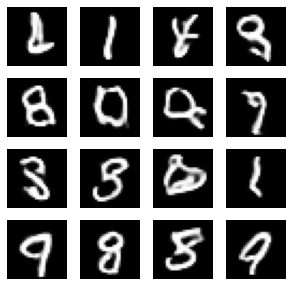

에포크 : 3800 생성자 손실 : 1.474 감별자 손실 : 0.486


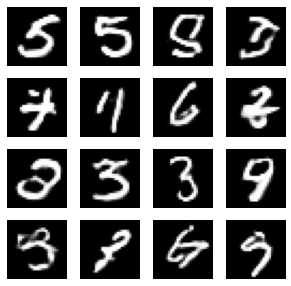

에포크 : 3900 생성자 손실 : 1.634 감별자 손실 : 0.453


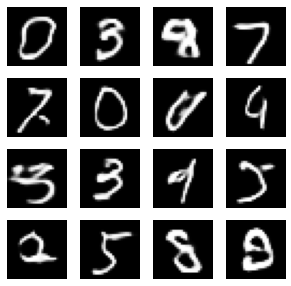

에포크 : 4000 생성자 손실 : 1.327 감별자 손실 : 0.522


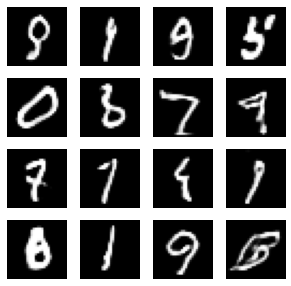

에포크 : 4100 생성자 손실 : 1.174 감별자 손실 : 0.550


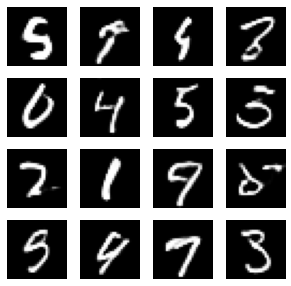

에포크 : 4200 생성자 손실 : 1.508 감별자 손실 : 0.484


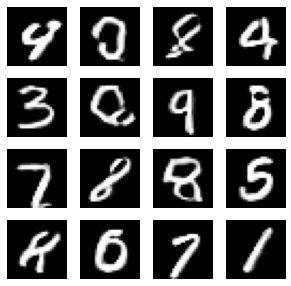

에포크 : 4300 생성자 손실 : 1.195 감별자 손실 : 0.559


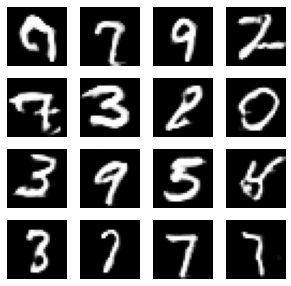

에포크 : 4400 생성자 손실 : 1.368 감별자 손실 : 0.549


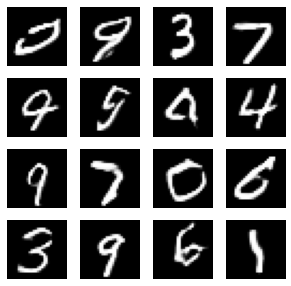

에포크 : 4500 생성자 손실 : 1.365 감별자 손실 : 0.554


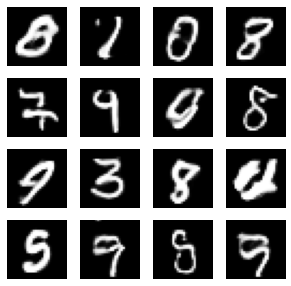

에포크 : 4600 생성자 손실 : 1.246 감별자 손실 : 0.573


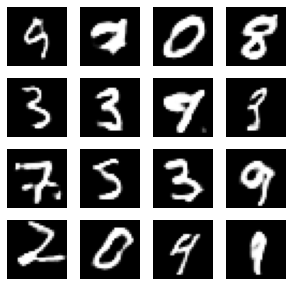

에포크 : 4700 생성자 손실 : 1.414 감별자 손실 : 0.516


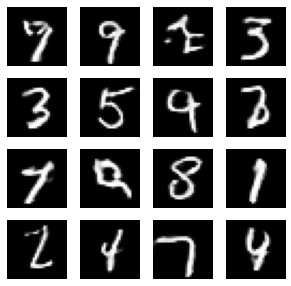

에포크 : 4800 생성자 손실 : 1.484 감별자 손실 : 0.532


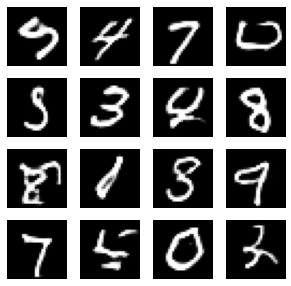

에포크 : 4900 생성자 손실 : 1.603 감별자 손실 : 0.472


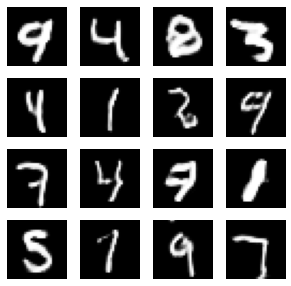

In [ ]:
# 데이터 처리
X_train = read_data() # X_train이 쓰이기 때문

# GAN 만들기
generator, discriminator, gan = build_GAN()

# 최종 GAN 학습
train_GAN()